In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [3]:
import tensorflow as tf

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/voc_multi_semantic_seg_dataset/PNGImages/*'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/voc_multi_semantic_seg_dataset/SegmentationClassPNG/*'
whu_image_directory = '../Satellite_dataset(global cities)/image/*'
whu_mask_directory = '../Satellite_dataset(global cities)/label/*'

In [7]:
image_names = glob.glob(whu_image_directory)
image_names

['../Satellite_dataset(global cities)/image\\10_0.tif',
 '../Satellite_dataset(global cities)/image\\10_1.tif',
 '../Satellite_dataset(global cities)/image\\10_2.tif',
 '../Satellite_dataset(global cities)/image\\10_3.tif',
 '../Satellite_dataset(global cities)/image\\11_0.tif',
 '../Satellite_dataset(global cities)/image\\11_1.tif',
 '../Satellite_dataset(global cities)/image\\11_2.tif',
 '../Satellite_dataset(global cities)/image\\11_3.tif',
 '../Satellite_dataset(global cities)/image\\12_0.tif',
 '../Satellite_dataset(global cities)/image\\12_1.tif',
 '../Satellite_dataset(global cities)/image\\12_2.tif',
 '../Satellite_dataset(global cities)/image\\12_3.tif',
 '../Satellite_dataset(global cities)/image\\13_0.tif',
 '../Satellite_dataset(global cities)/image\\13_1.tif',
 '../Satellite_dataset(global cities)/image\\13_2.tif',
 '../Satellite_dataset(global cities)/image\\13_3.tif',
 '../Satellite_dataset(global cities)/image\\14_0.tif',
 '../Satellite_dataset(global cities)/image\\14_

In [8]:
mask_names = glob.glob(whu_mask_directory)
mask_names

['../Satellite_dataset(global cities)/label\\10_0.tif',
 '../Satellite_dataset(global cities)/label\\10_1.tif',
 '../Satellite_dataset(global cities)/label\\10_2.tif',
 '../Satellite_dataset(global cities)/label\\10_3.tif',
 '../Satellite_dataset(global cities)/label\\11_0.tif',
 '../Satellite_dataset(global cities)/label\\11_1.tif',
 '../Satellite_dataset(global cities)/label\\11_2.tif',
 '../Satellite_dataset(global cities)/label\\11_3.tif',
 '../Satellite_dataset(global cities)/label\\12_0.tif',
 '../Satellite_dataset(global cities)/label\\12_1.tif',
 '../Satellite_dataset(global cities)/label\\12_2.tif',
 '../Satellite_dataset(global cities)/label\\12_3.tif',
 '../Satellite_dataset(global cities)/label\\13_0.tif',
 '../Satellite_dataset(global cities)/label\\13_1.tif',
 '../Satellite_dataset(global cities)/label\\13_2.tif',
 '../Satellite_dataset(global cities)/label\\13_3.tif',
 '../Satellite_dataset(global cities)/label\\14_0.tif',
 '../Satellite_dataset(global cities)/label\\14_

In [9]:
image_names.sort()
images = [cv2.imread(img) for img in image_names]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis=3)

In [10]:
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)

In [11]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (204, 512, 512, 3)
Mask data shape is:  (204, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


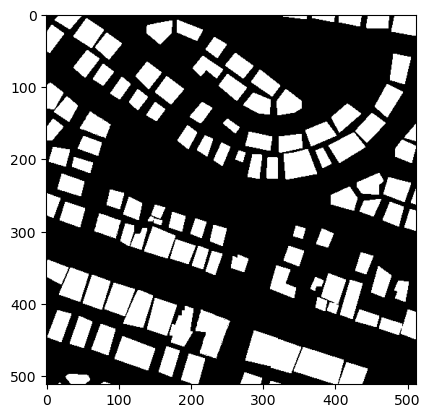

In [12]:
plt.imshow(mask_dataset[0, :, :, 0], cmap='gray')

In [13]:
mask_labels = np.unique(mask_dataset)
for mask in mask_dataset:
    for i, val in enumerate(mask_labels):
        mask[mask == val] = i
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1]


In [14]:
#binary segmentation
for mask in mask_dataset:
    mask[mask > 0] = 1
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1]


In [15]:
image_dataset = image_dataset / 255.
# mask_dataset = mask_dataset /255.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.20, random_state=42)

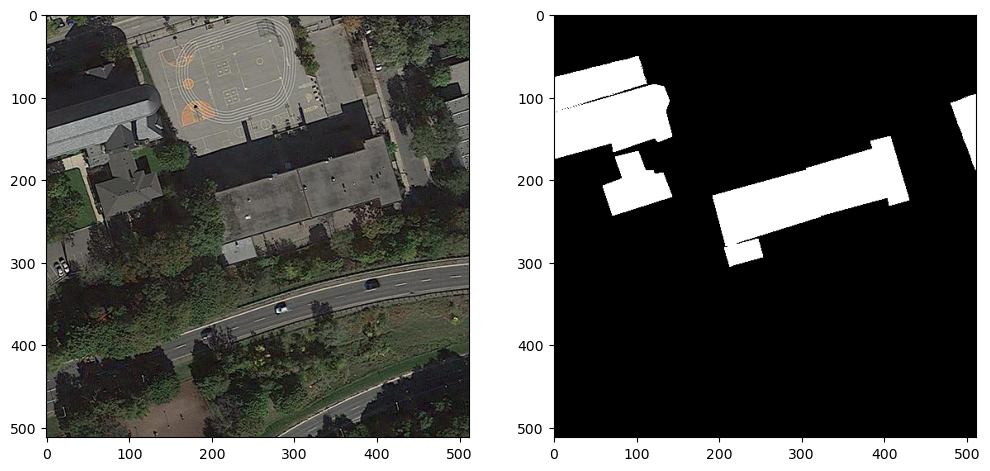

In [17]:
import random

image_number = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :, :, :])
plt.subplot(122)
plt.imshow(y_train[image_number, :, :, 0], cmap='gray')
plt.show()

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate, Add, Multiply

def bottleneck_block(input, num_filters):
    x_skip = Conv2D(num_filters, kernel_size=(1,1), padding="same")(input)
    x_skip = BatchNormalization(axis=3)(x_skip)

    x = Conv2D(num_filters/4, kernel_size=(1,1), padding="same")(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters/4, kernel_size=(3,3), padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, kernel_size=(1,1), padding="same")(x)
    x = BatchNormalization(axis=3)(x)

    x = Add()([x, x_skip])
    x = Activation("relu")(x)

    return x

def attention_gate(skip_input, gate_signal):
    num_filters = skip_input.shape[3]

    x = Conv2D(num_filters, kernel_size=(1,1), padding="same")(skip_input)

    x_gate = Conv2DTranspose(num_filters, kernel_size=(1,1), strides=2, padding="same")(gate_signal)
    x_gate = Conv2D(num_filters, kernel_size=(1, 1), padding="same")(x_gate)

    x = Add()([x, x_gate])
    x = Activation("relu")(x)
    x = Conv2D(num_filters, kernel_size=(1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    x = Multiply()([skip_input, x])

    return x

def aspp(input, num_filers):
    input_filters = input.shape[3]

    x1 = Conv2D(input_filters, kernel_size=(3,3), padding="same")(input)
    x2 = Conv2D(input_filters, kernel_size=(3,3), dilation_rate=6, padding='same')(input)
    x3 = Conv2D(input_filters, kernel_size=(3,3), dilation_rate=12, padding='same')(input)
    x4 = Conv2D(input_filters, kernel_size=(3,3), dilation_rate=18, padding='same')(input)

    x = Add()([x1, x2, x3, x4])
    x = Conv2D(num_filers, kernel_size=(1,1), padding="same")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters, num_bottlenecks):
    s = bottleneck_block(input, num_filters)
    for _ in range(num_bottlenecks-1):
        s = bottleneck_block(s, num_filters)

    p = Conv2D(num_filters, kernel_size=(1,1), strides=2, padding="same")(s)
    return s, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    input_filters = input.shape[3]

    x = Conv2DTranspose(input_filters, kernel_size=(2, 2), strides=2, padding="same")(input)

    gate_features = attention_gate(skip_features, input)
    x = Concatenate()([x, gate_features])

    x = Conv2D(num_filters, kernel_size=(3,3), padding="same")(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, kernel_size=(3,3), padding="same")(x)
    x = Activation("relu")(x)

    return x


#Build net using the blocks
def build_net(input_shape, n_classes):
    inputs = Input(input_shape)

    p0 = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding="same")(inputs)

    s1, p1 = encoder_block(p0, num_filters=128, num_bottlenecks=3)

    s2, p2 = encoder_block(p1, num_filters=256, num_bottlenecks=4)

    s3, p3 = encoder_block(p2, num_filters=512, num_bottlenecks=6)

    s4, _ = encoder_block(p3, num_filters=1024, num_bottlenecks=3)

    b1 = aspp(s4, 512)  #Bridge

    d1 = decoder_block(b1, s3, 512)
    d2 = decoder_block(d1, s2, 256)
    d3 = decoder_block(d2, s1, 128)

    d4 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=2, padding="same")(d3)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(filters=n_classes, kernel_size=(1,1), padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="AG-ResNet")
    return model

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/saved_models/checkpoints/with_whu/weights.159_{epoch:02d}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=False,
    save_freq=600,
    verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                           patience=10)

In [20]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [21]:
print(image_dataset.shape)

(204, 512, 512, 3)


In [22]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_net(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

sigmoid
Model: "AG-ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 32  2080        ['conv2d[0][0]']                 
                                )                                                 

In [26]:
history = model.fit(X_train, y_train,
                    batch_size=1,
                    verbose=1,
                    epochs=60,
                    validation_data=(X_test, y_test),
                    callbacks=[model_checkpoint_callback],
                    shuffle=False)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# model.load_weights('/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/saved_models/checkpoints/with_whu/weights.159_98.hdf5')

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/saved_models/ag_resnet_whu_60.hdf5')

In [ ]:
y_pred=model.predict(X_test[0:25])
y_pred_thresholded = y_pred > 0.5
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test[0:25])
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
for i in range(1):
  threshold = 0.5
  test_img_number = random.randint(0, len(X_test)-1)
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  print(test_img_input.shape)
  prediction = (model.predict(test_img_input)[0,:,:,:] > 0.5).astype(np.uint8)
  print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:])
  plt.subplot(232)
  plt.title('Testing Label')

  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction[:,:,0], cmap='gray')

  plt.show()

  # im = Image.fromarray((test_img[:,:]*255).astype(np.uint8))
  # ref = Image.fromarray((ground_truth[:,:,0]*255).astype(np.uint8))
  # res = Image.fromarray((prediction[:,:,0]*255).astype(np.uint8))
  # im.save(f"/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/unet/im{test_img_number}.png")
  # ref.save(f"/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/unet/ref{test_img_number}.png")
  # res.save(f"/content/drive/MyDrive/Colab Notebooks/SatelliteBuildingRecognition/unet/res{test_img_number}.png")